In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# Utiliser un réseau pré-entrainé

Une approche commune très efficace d’apprentissage en profondeur sur des jeux de données d’image de petite taille consiste à exploiter un réseau pré-formé. 


Un réseau pré-formé est simplement un réseau enregistré préalablement sur un grand ensemble de données


Si cet ensemble de données d'origine est suffisamment volumineux et assez général, la hiérarchie des caractéristiques spatiales apprises par le réseau pré-formé peut efficacement servir de modèle générique de notre monde visuel. 


Par exemple, on peut former un réseau sur ImageNet (où les classes sont principalement des animaux et des objets de la vie quotidienne), puis réutiliser ce réseau ainsi formé pour quelque chose d'aussi distant que l'identification d'éléments de mobilier dans des images. 


Cette transférabilité des caractéristiques acquises sur différents problèmes constitue un avantage essentiel de l’apprentissage en profondeur par rapport à de nombreuses anciennes méthodes d’apprentissage peu profondes, et rend l’apprentissage en profondeur très efficace pour les problèmes de petites données.


Dans notre cas, nous allons considérer un grand réseau convnet formé sur le jeu de données ImageNet (1,4 million d’images étiquetées et 1 000 classes différentes).


ImageNet contient de nombreuses classes d'animaux, y compris différentes espèces de chats et de chiens, et nous pouvons donc nous attendre à de très bonnes performances pour notre problème de classification chats contre chiens.


Nous utiliserons l'architecture VGG16, développée par Karen Simonyan et Andrew Zisserman en 2014, une architecture convnet simple et largement utilisée pour ImageNet.

## Extraction de caractéristiques

L'extraction de caractéristiques consiste à utiliser les représentations apprises par un réseau précédent pour extraire des caractéristiques intéressantes de nouveaux échantillons.


Ces fonctionnalités sont ensuite exécutées dans un nouveau classificateur, formé à partir de rien.


"L'extraction de caractéristiques" consistera simplement à prendre la base convolutionnelle d'un réseau préalablement formé, en exécutant les nouvelles données et former un nouveau classificateur par-dessus la sortie.

Mettons cela en pratique en utilisant la base convolutionnelle du réseau VGG16, formée sur ImageNet, pour extraire des fonctionnalités intéressantes de
nos images de chat et de chien, puis l’entraînement d’un classifieur chat / chien au-dessus de ces caractéristiques.

Le modèle VGG16, entre autres, est livré pré-emballé avec Keras. Vous pouvez l'importer à partir du module `keras.applications`. Voici la liste des
Modèles de classification d'images (tous pré-formés sur le jeu de données ImageNet) disponibles dans le cadre de `keras.applications`:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Instancions le modèle VGG16:

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 5s 0us/step


Nous avons passé trois arguments au constructeur:

* `weights` pour spécifier le point de contrôle de la pondération à partir duquel initialiser le modèle
* `include_top`, qui fait référence à l'inclusion ou non du classifieur densément connecté au sommet du réseau. Par défaut, ce classificateur densément connecté correspondrait aux 1000 classes d’ImageNet. Comme nous avons l’intention d’utiliser notre propre réseau classificateur, nous n'avons pas besoin de l'inclure.
* `input_shape`, la forme des tenseurs d'image que nous allons fournir au réseau. Cet argument est purement optionnel: si nous ne le passons pas, le réseau pourra alors traiter les entrées de toutes tailles.

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

La carte de caractéristiques finale a la forme `(4, 4, 512)`. C'est la caractéristique sur laquelle nous allons coller un classificateur densément connecté.


À ce stade, nous pourrions procéder de deux manières:

* Exécuter la base de convolution sur notre ensemble de données, enregistrer sa sortie dans un tableau Numpy sur disque, puis utiliser ces données comme entrée du classificateur autonome dense. 


* Étendre le modèle que nous avons (`conv_base`) en ajoutant des couches` Dense` en haut, et en exécutant le tout de bout en bout sur les données en entrée.


In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-01-17 22:00:39--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 2404:6800:4008:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  78.3MB/s    in 0.8s    

2019-01-17 22:00:41 (78.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [7]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print( train_dog_fnames[:10])

['cat.807.jpg', 'cat.888.jpg', 'cat.788.jpg', 'cat.219.jpg', 'cat.26.jpg', 'cat.579.jpg', 'cat.920.jpg', 'cat.625.jpg', 'cat.45.jpg', 'cat.995.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

This is what our model looks like now:

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [12]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [0]:
conv_base.trainable = False

In [14]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [18]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer="rmsprop",
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 27s - loss: 0.3734 - acc: 0.8320 - val_loss: 0.3786 - val_acc: 0.8480
Epoch 2/30
 - 26s - loss: 0.3512 - acc: 0.8400 - val_loss: 0.2656 - val_acc: 0.8880
Epoch 3/30
 - 25s - loss: 0.3472 - acc: 0.8440 - val_loss: 0.2639 - val_acc: 0.8770
Epoch 4/30
 - 26s - loss: 0.3209 - acc: 0.8610 - val_loss: 0.2765 - val_acc: 0.8880
Epoch 5/30
 - 26s - loss: 0.3266 - acc: 0.8565 - val_loss: 0.2835 - val_acc: 0.8790
Epoch 6/30
 - 26s - loss: 0.3243 - acc: 0.8510 - val_loss: 0.2800 - val_acc: 0.8760
Epoch 7/30
 - 26s - loss: 0.3123 - acc: 0.8635 - val_loss: 0.2690 - val_acc: 0.8800
Epoch 8/30
 - 26s - loss: 0.3053 - acc: 0.8635 - val_loss: 0.3134 - val_acc: 0.8680
Epoch 9/30
 - 26s - loss: 0.2980 - acc: 0.8625 - val_loss: 0.2734 - val_acc: 0.8870
Epoch 10/30
 - 26s - loss: 0.3101 - acc: 0.8660 - val_loss: 0.3266 - val_acc: 0.8730
Epoch 11/30
 - 26s - loss: 0.2884 - acc: 0.8780 - val_loss: 0.2940 - val_ac

In [0]:
model.save('cats_and_dogs_small_3.h5')

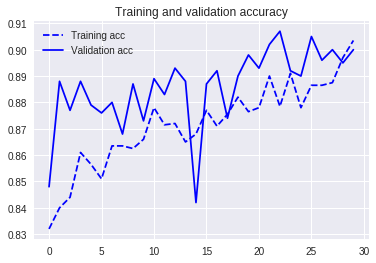

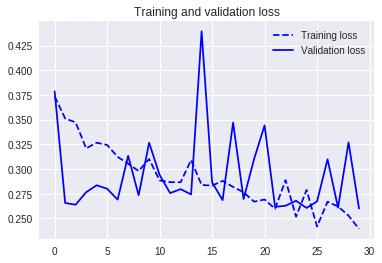

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()